# Tutorial 1: Querying Attributions

SIGnature enables querying gene set activation across multiple cell types. 

This tutorial goes through the steps for generating cell-level gene set scores for any gene signature of interest using our pre-defined cell type atlases.

Before running this tutorial, you need to:

1. Download the SCimilarity model from https://zenodo.org/records/15729925
2. Download the cell type-level attributions you are interested in from https://zenodo.org/communities/signature/. For this tutorial, you will need two attribution folders from Zenodo (https://zenodo.org/records/15794176):

    1. `celltype_attributions_lung`: contains data for the first part of the tutorial showing a simple querying example. This folder can be extracted with the command `tar -xzf celltype_attributions_lung.tar.gz`
    2. `celltype_attributions`: contains data from myeloid cells to replicate the MS1 signature analysis from the paper. This folder can be extracted with the command `tar -xzf celltype_attributions.tar.gz`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import join
import pandas as pd
import seaborn as sns
from SIGnature import SIGnature, SCimilarity, Meta
import tiledb
import time
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# Lung Example

Compare type I pneumocyte marker genes in that cell type and compare to ionocytes.

### Load SCimilarity Model and Attributions TileDB

In [2]:
## Path to Scimilarity Model Downloaded from Zenodo (https://zenodo.org/records/15729925)
scim_model_path = "/home/scimilarity_model"
## Set use_gpu false when querying attributions
scim = SCimilarity(model_path=scim_model_path, use_gpu=False)

In [3]:
## Folder where the cell type attributions are stored
## Downloaded from Zenodo (https://zenodo.org/records/15794176)
ct_base = "/home/celltype_attributions_lung"
all_ct = os.listdir(ct_base)

### Check Genes

In [4]:
## Check genes (AT1 associated genes from CellMarker)
goi = ['CAV1', 'CAV2', 'CLIC5']
sig = SIGnature(gene_order=scim.gene_order, model=scim)
gene_list = sig.check_genes(goi)

### Calculate Mean Attribution Scores

In [5]:
ctoi = ["type I pneumocyte", "pulmonary ionocyte"]
score_name = "AT1"

In [6]:
meta_list = []
for ct in tqdm(ctoi):
    ## Get specific tiledb path for location of interest
    ct_path = join(ct_base, ct)
    ## Load attributions tiledb path for given cell type
    att_tdb_path = join(ct_path, "attributions")
    ## Calculate
    results = sig.query_attributions(
        gene_list,
        return_aggregate=True,
        aggregate_type="mean",
        attribution_tiledb_uri=att_tdb_path,
    )

    ## Example including weights
    # np.random.seed(114)
    # weight_list = np.random.choice([0.5, 1, 2], len(gene_list)).tolist()
    # results = sig.query_attributions(gene_list, return_aggregate=True, 
    #               aggregate_type='mean', weights = weight_list, 
    #               attribution_tiledb_uri=att_tdb_path)

    ## Example of getting individual genes
    # results = sig.query_attributions(gene_list, return_aggregate=False)

    ## Load corresponding cell metadata
    ct_path = join(ct_base, ct)
    meta = pd.read_csv(join(ct_path, "cell_metadata.csv.gz"), index_col=0)

    ## Put score
    meta[score_name] = results
    meta_list.append(meta.copy())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.88it/s]


### Analyze scores

Compare mean attribution scores for AT1 epithelial genes between AT1 cells and pulmonary ionocytes.

In [7]:
big_meta = pd.concat(meta_list)

Text(0.5, 0, 'Cell Type')

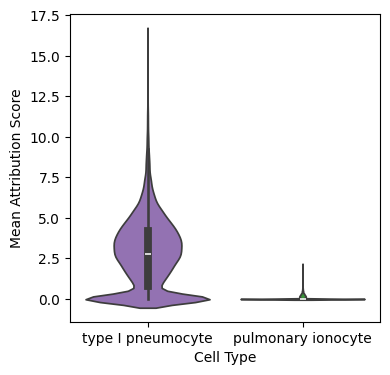

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.violinplot(
    data=big_meta,
    x="prediction",
    y="AT1",
    palette=["tab:purple", "tab:green"],
    density_norm='width'
)
ax.set_ylabel("Mean Attribution Score")
ax.set_xlabel("Cell Type")

# MS1 Example

Replicate analysis in paper by calculating mean attributions for MS1 gene set and comparing across disease.

### Load SCimilarity Model and Attributions TileDB

In [9]:
## Path to Scimilarity Model Downloaded from Zenodo (https://zenodo.org/records/15794176)
scim_model_path = "/home/scimilarity_model"
## Set use_gpu false when querying attributions
scim = SCimilarity(model_path=scim_model_path, use_gpu=False)

In [10]:
## This should be the folder where the attributions are stored
## Path to cell type attributions downloaded from Zenodo (https://zenodo.org/records/15794176)
ct_base = "/home/celltype_attributions"
all_ct = os.listdir(ct_base)

In [11]:
# Analyze all monocyte/macrophage cell populations in database
ctoi = [
    "alveolar macrophage",
    "classical monocyte",
    "intermediate monocyte",
    "macrophage",
    "non-classical monocyte",
]

In [12]:
ms1_genes = ['S100A8', 'S100A12', 'RETN', 'CLU', 'MCEMP1', 'IL1R2', 'CYP1B1', 'SELL', 
             'ALOX5AP', 'SLC39A8', 'PLAC8', 'ACSL1', 'CD163', 'VCAN', 'HP', 'CTSD', 
             'LGALS1', 'THBS1', 'CES1', 'S100P', 'ANXA6', 'VNN2', 'NAMPT', 'HAMP', 
             'DYSF', 'SDF2L1', 'NFE2', 'SLC2A3', 'BASP1', 'ADGRG3', 'SOD2', 'CTSA', 
             'PADI4', 'CALR', 'SOCS3', 'NKG7', 'FLOT1', 'IL1RN', 'ZDHHC19', 'LILRA5', 
             'ASGR2', 'FAM65B', 'MNDA', 'STEAP4', 'NCF4', 'LBR', 'RP11-295G20.2', 
             'UBR4', 'PADI2', 'NCF1', 'LINC00482', 'RUNX1', 'RRP12', 'HSPA1A', 
             'FLOT2', 'ANPEP', 'CXCR1', 'ECE1', 'ADAM19', 'RP11-196G18.3', 'IL4R', 
             'DNAJB11', 'FES', 'MBOAT7', 'SNHG25', 'RP1-55C23.7', 'CPEB4', 'PRR34-AS1', 
             'HSPA1B', 'LINC01001', 'C1QC', 'SBNO2', 'GTSE1', 'FOLR3', 'STAB1', 'PLK1', 
             'HYI-AS1', 'LINC01281', 'TNNT1', 'AC097495.2', 'CTB-35F21.5', 'C19orf35', 
             'AC109826.1', 'RP11-800A3.7', 'LILRA6', 'PDLIM7', 'NPLOC4', 'C15orf48', 
             'APOBR', 'CSF2RB', 'CTD-2105E13.14', 'C1QB', 'RP11-123K3.9', 'IQGAP3', 
             'GAPLINC', 'CTC-490G23.2', 'JAK3', 'CTC-246B18.10', 'MYO5B']

### Check genes

Subset the genes of interest to ones that are included in the SCimilarity model.

In [13]:
sig = SIGnature(gene_order=scim.gene_order, model=scim)
gene_list = sig.check_genes(ms1_genes)

The following genes are not included: C19orf35,AC097495.2,CTD-2105E13.14,CTC-246B18.10,FAM65B,CTC-490G23.2,HYI-AS1,RP11-295G20.2,RP11-800A3.7,RP1-55C23.7,RP11-123K3.9,CTB-35F21.5,RP11-196G18.3


In [14]:
len(gene_list)

86

### Calculate Mean Attribution Scores for each Cell Type

Iterate through tiledb of each cell type, calculate score, concatenate the metadata.

In [15]:
score_name = "MS1"

In [16]:
meta_list = []
for ct in tqdm(ctoi):
    ## Get specific tiledb path for location of interest
    ct_path = join(ct_base, ct)
    ## Load attributions tiledb path for given cell type
    att_tdb_path = join(ct_path, "attributions")
    ## Calculate
    results = sig.query_attributions(
        gene_list,
        return_aggregate=True,
        aggregate_type="mean",
        attribution_tiledb_uri=att_tdb_path,
    )

    ## Example including weights
    # np.random.seed(114)
    # weight_list = np.random.choice([0.5, 1, 2], len(gene_list)).tolist()
    # results = sig.query_attributions(gene_list, return_aggregate=True, 
    #               aggregate_type='mean', weights = weight_list, 
    #               attribution_tiledb_uri=att_tdb_path)

    ## Example of getting individual genes
    # results = sig.query_attributions(gene_list, return_aggregate=False, 
    #               attribution_tiledb_uri=att_tdb_path)

    ## Load corresponding cell metadata
    ct_path = join(ct_base, ct)
    meta = pd.read_csv(join(ct_path, "cell_metadata.csv.gz"), index_col=0)

    ## Put score
    meta[score_name] = results
    meta_list.append(meta.copy())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.32s/it]


In [17]:
big_meta = pd.concat(meta_list)

In [18]:
big_meta.head(5)

study      sample           prediction  fm_signature_score  \
298997  GSE160794  GSM4879379  alveolar macrophage            0.346716   
298998  GSE160794  GSM4879379  alveolar macrophage           -0.290656   
298999  GSE160794  GSM4879379  alveolar macrophage            0.695440   
299001  GSE160794  GSM4879379  alveolar macrophage           -0.030102   
299002  GSE160794  GSM4879379  alveolar macrophage            0.146310   

        n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
298997               3197       21991.0            959.0       4.360875   
298998               1167        3657.0            182.0       4.976757   
298999               3515       21938.0            598.0       2.725864   
299001               2906       14594.0            729.0       4.995203   
299002               3367       17256.0            536.0       3.106166   

        prediction_nn_dist  data_type  ...  ESC-derived  xenograft  tissue  \
298997            0.007285  unlabeled  ...        False      False    lung   
298998            0.011017  unlabeled  ...        False      False    lung   
298999            0.021277  unlabeled  ...        False      False    lung   
299001            0.011253  unlabeled  ...        False      False    lung   
299002            0.012170  unlabeled  ...        False      False    lung   

        cell_line_cleaned  disease FACS_sort sex_cleaned author_label  \
298997                NaN      NaN       NaN         NaN          NaN   
298998                NaN      NaN       NaN         NaN          NaN   
298999                NaN      NaN       NaN         NaN          NaN   
299001                NaN      NaN       NaN         NaN          NaN   
299002                NaN      NaN       NaN         NaN          NaN   

       celltype_index       MS1  
298997              0  0.460732  
298998              1  0.703938  
298999              2  0.433652  
299001              3  0.485425  
299002              4  0.561418  

[5 rows x 26 columns]

### Analyze Scores

Load metadata into "Meta" object to perform gene signature analysis.

#### Load and Filter Metadata

In [19]:
## Create a Meta object to manipulate the dataframe and perform standardized actions
momac_meta = Meta(big_meta)
## Subset to high quality cells (SCimilarity prediction dist <0.02)
momac_meta.subset_hq()
## Subset to only in vivo cells
momac_meta.subset_invivo()

In [20]:
ncell = momac_meta.df.shape[0]
nsamp = momac_meta.df["sample"].nunique()
nstudy = momac_meta.df["study"].nunique()
print(
    f"Analyzing {ncell} monocytes and macrophages from {nsamp} samples in {nstudy} studies"
)

Analyzing 2338447 monocytes and macrophages from 3443 samples in 244 studies


In [21]:
### Clarify some disease names for downstream figure
figure_disname_dict = {
    "atopic eczema": "Atopic Dermatitis",
    "COVID-19;healthy": "COVID-19 & Healthy (Mixed)",
    "Epstein-Barr virus infection;hemophagocytic syndrome": "EBV-Associated HLH",
    "Immune dysregulation-polyendocrinopathy-enteropathy-X-linked syndrome": "IPEX",
    "mucocutaneous lymph node syndrome": "Kawasaki Disease",
    "systemic scleroderma;interstitial lung disease": "SSC-ILD",
    "thrombocytopenia": "Severe Fever Thrombocytopenia Syndrome",
}

momac_meta.df["disease"] = [
    figure_disname_dict.get(x, x) for x in momac_meta.df["disease"]
]

#### Define "Hits" Based on Cutoff

Show multiple options for how to define hits and add to metadata (e.g., 90th percentile, 0.95 quantile, 2 standard deviations above the mean).

In [22]:
hit_col = "MS1"
## 90th percentile
momac_meta.add_hits(
    column_name=hit_col,
    mode="percentile",
    cut_val=90,
    hit_type="above",
    string_append="__hit90p",
)

## Above 0.95 quantile
# momac_meta.add_hits(
#     column_name=hit_col,
#     mode="quantile",
#     cut_val=0.95,
#     hit_type="above",
#     string_append="__hit95p",
# )

## Above set value (2 stdev above mean)
# mean = np.mean(momac_meta[hit_col].values)
# std = np.std(momac_meta[hit_col].values)
# hit_val = mean + (2 * std)
# momac_meta.add_hits(
#     column_name=hit_col,
#     mode="value",
#     cut_val=hit_val,
#     hit_type="above",
#     string_append="__2zscore",
# )

#### Calculate hit percentage per sample

For all the monocytes/macrophages in each sample, calculate the percentage that are hits. Only consider samples with at least 25 monocytes/macrophages and diseases that have at least 3 samples. Then show the top 10 diseases by mean hit percentage.

In [23]:
samphit_df_90 = momac_meta.samphit_df(
    cell_min=25, samp_min=3, hit_col="MS1__hit90p", num_dis=10
)

#### Generate sample boxplot (like figure 4a)

In [24]:
title = "MS1-like Cells in SCimilarity Database"

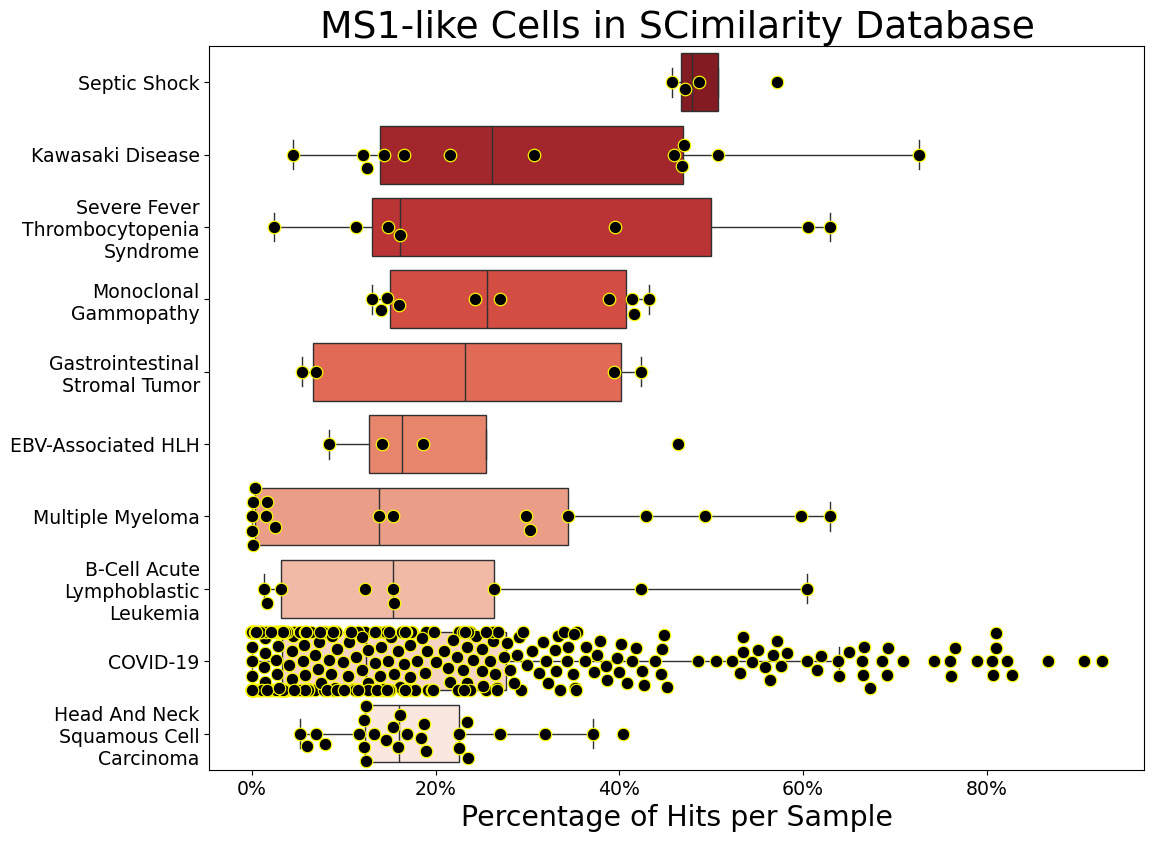

In [25]:
Meta.samphit_boxplot(
    samphit_df_90,
    hit_label="MS1__hit90p",
    swarm=True,
    figsize=(11.5, 8.5),
    fe=1.7,
    title=title,
    dotsize=9,
)